<a href="https://colab.research.google.com/github/mmagavi/FinalProject1291/blob/main/FirstModel_FinalProject1291.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Classifying Brain Tumors With Convolutional Neural Networks and Vision Transformer**

**Model:** VGG-19 \
**Source:** http://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.VGG19_Weights


## **Importing the Data**

Importing the data from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

**cjdata.label:** 1 for meningioma, 2 for glioma, 3 for pituitary tumor

**cjdata.PID:** patient ID

**cjdata.image:** image data

**cjdata.tumorBorder:** a vector storing the coordinates of discrete points on tumor border.

		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.

**cjdata.tumorMask:** a binary image with 1s indicating tumor region


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing and Downloading Images

!gdown 1p_q_wHJZQIEeinSUskvQHtqu88s2gfq82!gdown 1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
!gdown 1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
!gdown 1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
!unzip brainTumorDataPublic_22993064.zip -d tumor_data
!unzip brainTumorDataPublic_15332298.zip -d tumor_data
!unzip brainTumorDataPublic_7671532.zip -d tumor_data
!unzip brainTumorDataPublic_1766.zip -d tumor_data

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY] [--speed SPEED]
             [--no-cookies] [--no-check-certificate] [--continue] [--folder] [--remaining-ok]
             url_or_id
gdown: error: unrecognized arguments: 1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
Downloading...
From: https://drive.google.com/uc?id=1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
To: /content/brainTumorDataPublic_7671532.zip
100% 218M/218M [00:01<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
To: /content/brainTumorDataPublic_1766.zip
100% 214M/214M [00:01<00:00, 115MB/s]
unzip:  cannot find or open brainTumorDataPublic_22993064.zip, brainTumorDataPublic_22993064.zip.zip or brainTumorDataPublic_22993064.zip.ZIP.
unzip:  cannot find or open brainTumorDataPublic_15332298.zip, brainTumorDataPublic_15332298.zip.zip or brainTumorDataPublic_15332298.zip.ZIP.
Archive:  brainTumorDataPublic_7671532.zip
  inflating: tumor_data/1000.mat     
  inflating: tumor

# **Creating a VGG19 Model, Evaluating & Training it on our Data**

*   Import packages and instantiate a model
*   Preprocessing images


In [3]:
%env CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#SETUP
import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchsummary import summary
import json
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)


# Instantiate a model, check the structure

vgg19 = models.vgg19(weights="IMAGENET1K_V1")
vgg19.to(device)
vgg19.eval()

summary(vgg19, (3, 224, 224))


env: CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
Running on cuda:0


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.8MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [4]:
import h5py

image_path = "tumor_data/1524.mat" # using one image to see model works

# Open the .mat file using h5py
with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    patient_id = file['cjdata']['PID'][()][0, 0]
    image_data = file['cjdata']['image'][()]
    tumor_border = file['cjdata']['tumorBorder'][()].flatten()



*   Creating a prediction on our data with the original VGG19 Model (unmodified by us)



In [5]:
# Similar code to assignment 7
# Preprocessing images
!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj #imagenet_classes.json


def preprocess(image_data):
    data = np.repeat(image_data[..., np.newaxis], 3, -1)
    image = Image.fromarray((data * 255).astype(np.uint8))

    # Resize and normalize using PyTorch transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    normalized_image = transform(image)
    #print(normalized_image.shape)
    return normalized_image


PATH_TO_LABELS = 'imagenet_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
    imagenet_classes = json.load(f)


def decode_preds(outputs, class_names=imagenet_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')


Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 50.9MB/s]




*   Display the image, alongside the prediction




Class: book jacket, dust cover, dust jacket, dust wrapper, Probability: 0.06292116641998291


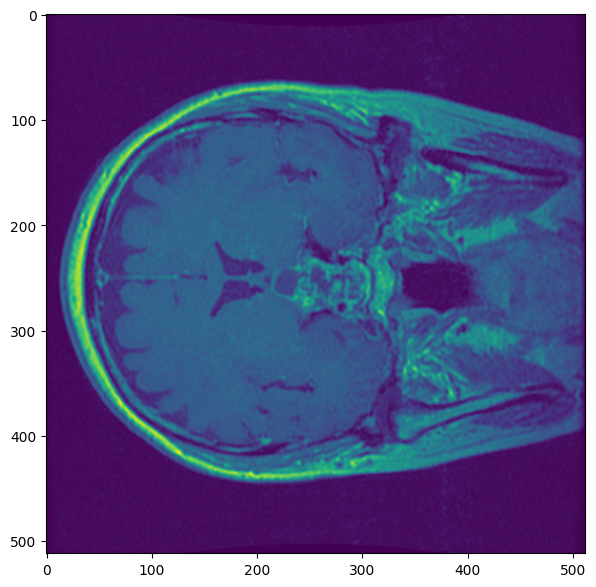

In [6]:
array = preprocess(image_data) #.to(device)

with torch.no_grad():
  vector = vgg19(array[None, :, :, :].cuda())

# Display the image
plt.imshow(image_data) #coloured by plt.imshow()
decode_preds(vector)

## **Fine tuning the model**

In [7]:
from sklearn.model_selection import train_test_split
import shutil

# Create a Training, Testing, and Validation set

path = "tumor_data"
file_paths = [os.path.join(path, file) for file in os.listdir(path)]
train_files, test_val_files = train_test_split(file_paths, test_size=0.2, random_state=42)
test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

def move_files(file_list, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for file in file_list:
        shutil.move(file, destination_folder)

# Move files to their folders
move_files(train_files, "tumor_data/train")
move_files(val_files, "tumor_data/validate")
move_files(test_files, "tumor_data/test")


In [8]:
class CustomMatDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Open the .mat file using h5py
        with h5py.File(file_path, 'r') as file:
            label = file['cjdata']['label'][()][0, 0]
            label = label - 1
            image_data = file['cjdata']['image'][()]

        if self.transform:
            image = self.transform(image_data)

        return image, label

train_dataset = CustomMatDataset(folder_path='tumor_data/train', transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomMatDataset(folder_path='tumor_data/test', transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

validate_dataset = CustomMatDataset(folder_path='tumor_data/validate', transform=preprocess)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True)


In [9]:
#class names
class_names = {
    0: "meningioma",
    1: "glioma",
    2: "pituitary tumor",
}

**Creating a new model for fine-tuning**

In [10]:
standard_vgg19 = models.vgg19(weights="IMAGENET1K_V1").to(device)

# Freeze the layers of the standard VGG19
for param in standard_vgg19.parameters():
    param.requires_grad = False

# Modify the model for 3-class classification of Brain images
# Remove the fully connected layers (classifier) on top
standard_vgg19.classifier = nn.Identity()

# Now create a new model with the features of the standard VGG19 and a new classifier
class NewVGG19(nn.Module):
    def __init__(self):
        super(NewVGG19, self).__init__()
        self.features = standard_vgg19.features
        # self.avgpool = standard_vgg19.avgpool
        # self.oldvgg = standard_vgg19
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 3),  #3 classes of tumours
        )

    def forward(self, x):
        x = self.features(x) # Akash: This is what it should be, you want to extract
                             # only the features, and then add your classifier over that
        x = self.classifier(x)
        return x

new_vgg19 = NewVGG19()

print(new_vgg19)

NewVGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

***Train, test and validate the model***

In [11]:
# Helper function train() trains model for epoch epochs and returns a list of
# validation accuracies
def train(model, epochs, lr, trainloader, valloader, testloader):

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss().cuda()
  adam_optimizer = optim.Adam(model.parameters(), lr)

  accs = []
  model = model.cuda()
  for epoch in range(epochs):
      total_loss = 0

      for (batch_X, batch_y) in trainloader:
          # Zero the gradients
          adam_optimizer.zero_grad()
          # Forward pass
          outputs = model(batch_X.cuda())
          # Compute the loss
          loss = criterion(outputs, batch_y.long().cuda())
          # Backward pass
          loss.backward()
          # Update weights
          adam_optimizer.step()
          total_loss += loss.item()
      # Print average loss for the epoch
      print(f"Epoch {epoch + 1}, Loss: {total_loss / len(trainloader):.4f}")

      # Validation
      model.eval()
      with torch.no_grad():
        val_acc = []
        for (batch_X, batch_y) in valloader:
          val_outputs = model(batch_X.cuda())
          val_loss = criterion(val_outputs, batch_y.long().cuda())

          # If y_val is one-hot encoded
          _, val_preds = torch.max(val_outputs, 1)
          # _, yv = torch.max(batch_y, 1)

          val_acc.append((val_preds == batch_y.cuda()).float().mean().item())
        accs.append(np.mean(val_acc))

      print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {np.mean(val_acc):.4f}")

  # Testing
  model.eval()
  with torch.no_grad():

    test_acc = []

    for (batch_X, batch_y) in testloader:
      test_outputs = model(batch_X.cuda())
      test_loss = criterion(test_outputs, batch_y.long().cuda())

      # If y_val is one-hot encoded
      _, test_preds = torch.max(test_outputs, 1)
      # _, yv = torch.max(batch_y, 1)

      test_acc.append((test_preds == batch_y.long().cuda()).float().mean().item())

  print("TEST ACCURACY AND LOSS: ")
  print(f"TEST Loss: {test_loss.item():.4f}, TEST Accuracy: {np.mean(test_acc):.4f}")

  return accs


# Call train() for 10 epochs with lr 0.001
val_accs = train(new_vgg19, 10, 0.0001, train_loader, validate_loader, test_loader)

print("Validation accuracies over epoch: ")
print(val_accs)

Epoch 1, Loss: 0.5751
Validation Loss: 0.3367, Validation Accuracy: 0.8817
Epoch 2, Loss: 0.2744
Validation Loss: 0.2337, Validation Accuracy: 0.8909
Epoch 3, Loss: 0.2075
Validation Loss: 0.2543, Validation Accuracy: 0.9019
Epoch 4, Loss: 0.1519
Validation Loss: 0.1725, Validation Accuracy: 0.9034
Epoch 5, Loss: 0.1295
Validation Loss: 0.1937, Validation Accuracy: 0.9221
Epoch 6, Loss: 0.1044
Validation Loss: 0.2315, Validation Accuracy: 0.9130
Epoch 7, Loss: 0.0833
Validation Loss: 0.1497, Validation Accuracy: 0.9221
Epoch 8, Loss: 0.0708
Validation Loss: 0.1214, Validation Accuracy: 0.9375
Epoch 9, Loss: 0.0625
Validation Loss: 0.1348, Validation Accuracy: 0.9173
Epoch 10, Loss: 0.0532
Validation Loss: 0.1515, Validation Accuracy: 0.9144
TEST ACCURACY AND LOSS: 
TEST Loss: 0.1689, TEST Accuracy: 0.9090
Validation accuracies over epoch: 
[0.8817307710647583, 0.8908653974533081, 0.9019230842590332, 0.9033653974533081, 0.9221153974533081, 0.9129807710647583, 0.9221153974533081, 0.9375,

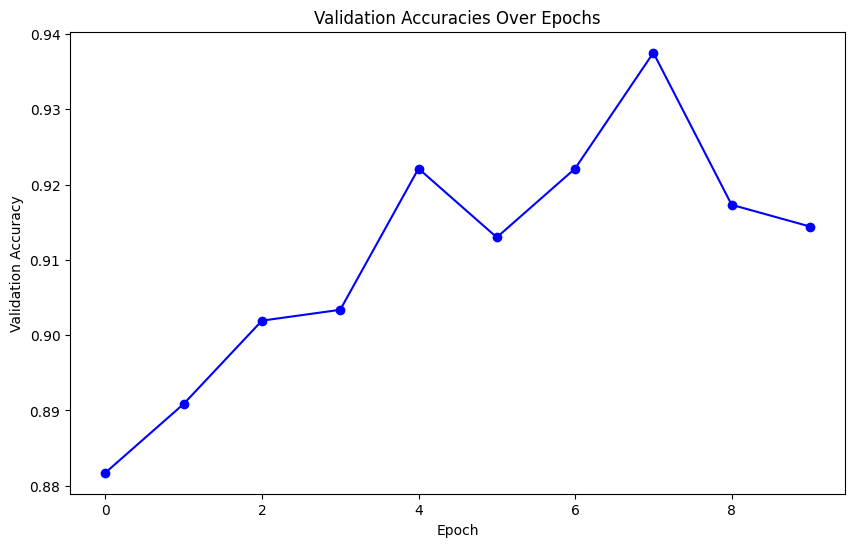

In [12]:
# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val_accs, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

## **Notes on training model**

### **Testing out a variety of hyperparameters**

**Round 1: 10 epochs, lr = 0.01**

TEST ACCURACY AND LOSS:
Loss: 0.6628, Accuracy: 0.8764

Validation accuracies over epoch:
[0.7664473712444305, 0.871875, 0.8320723712444306, 0.8978618443012237, 0.8717105269432068, 0.861348682641983, 0.8873355269432068, 0.8853618443012238, 0.798848682641983, 0.876973682641983]

**Round 2: 10 epochs, lr = 0.005**

TEST ACCURACY AND LOSS:
Loss: 0.6075, Accuracy: 0.8663

Validation accuracies over epoch:
[0.8111842095851898, 0.8603618443012238, 0.864473682641983, 0.8603618443012238, 0.8728618443012237, 0.8799342095851899, 0.8707236826419831, 0.883223682641983, 0.892598682641983, 0.8726973712444306]

**Round 3: 10 epochs, lr = 0.05**

TEST ACCURACY AND LOSS:
Loss: 0.8848, Accuracy: 0.6667

Validation accuracies over epoch:
[0.6453947365283966, 0.5559210538864136, 0.5409539461135864, 0.5546052634716034, 0.5944078922271728, 0.6225328922271729, 0.6319078922271728, 0.6182565808296203, 0.6286184221506119, 0.6328947365283966]

**Round 4: 15 epochs, lr = 0.001**

TEST ACCURACY AND LOSS:

Loss: 0.7737, Accuracy: 0.6684

Validation accuracies over epoch:

[0.6276315808296203, 0.6319078922271728, 0.6276315808296203, 0.6297697365283966, 0.6276315808296203, 0.6297697365283966, 0.6297697365283966, 0.6319078922271728, 0.6276315808296203, 0.6276315808296203, 0.6361842095851898, 0.6297697365283966, 0.6233552634716034, 0.6340460538864136, 0.6319078922271728]

**Round 5: 20 epochs, lr = 0.01**

TEST ACCURACY AND LOSS:
Loss: 0.8292, Accuracy: 0.9035

Validation accuracies over epoch:
[0.6746710538864136, 0.7152960538864136, 0.6935855269432067, 0.7746710538864136, 0.864473682641983, 0.8498355269432067, 0.8351973712444305, 0.820723682641983, 0.89375, 0.8634868443012238, 0.8842105269432068, 0.8791118443012238, 0.864473682641983, 0.883223682641983, 0.8884868443012237, 0.8875, 0.889473682641983, 0.8916118443012238, 0.889473682641983, 0.89375]

Final accuracy for lr = 0.01, 20 epochs:
**0.8986**

**Round 6: 20 epochs, lr = 0.01 Again**

TEST ACCURACY AND LOSS:
Loss: 6.0714, Accuracy: 0.8572

Validation accuracies over epoch:
[0.7225961565971375, 0.9269230842590332, 0.923557698726654, 0.9408653974533081, 0.9302884697914123, 0.8956730842590332, 0.9192307710647583, 0.9485576987266541, 0.9346153974533081, 0.91875, 0.929807698726654, 0.9192307710647583, 0.9173076987266541, 0.9283653974533081, 0.923557698726654, 0.9485576987266541, 0.9269230842590332, 0.9331730842590332, 0.9206730842590332, 0.898557698726654]


**Round 7: 10 epochs, lr = 0.05**

TEST ACCURACY AND LOSS:
Loss: 6.7224, Accuracy: 0.9152

Validation accuracies over epoch:
[0.8677884697914123, 0.9221153974533081, 0.923557698726654, 0.9158653974533081, 0.9177884697914124, 0.9254807710647583, 0.9423076987266541, 0.9331730842590332, 0.9283653974533081, 0.936057698726654]

**Round 8: 10 epochs, lr = 0.001**

TEST ACCURACY AND LOSS:
Loss: 0.3872, Accuracy: 0.8947

Validation accuracies over epoch:
[0.8831730842590332, 0.923557698726654, 0.95, 0.9456730842590332, 0.954807698726654, 0.9533653974533081, 0.9471153974533081, 0.95625, 0.9471153974533081, 0.9408653974533081]

**Round 9: 10 epochs, lr = 0.0005**

TEST ACCURACY AND LOSS:
Loss: 0.2056, Accuracy: 0.8965

Validation accuracies over epoch:
[0.9081730842590332, 0.936057698726654, 0.9221153974533081, 0.925, 0.9423076987266541, 0.9206730842590332, 0.929807698726654, 0.9331730842590332, 0.9375, 0.929807698726654]

**Round 10: 10 epochs, lr = 0.0001**

TEST ACCURACY AND LOSS:
Loss: 0.1074, Accuracy: 0.9107

Validation accuracies over epoch:
[0.8567307710647583, 0.8879807710647583, 0.8971153974533081, 0.9038461565971374, 0.9173076987266541, 0.9129807710647583, 0.923557698726654, 0.9206730842590332, 0.929807698726654, 0.9177884697914124]

In [13]:
# New decode preds for brain data

def decode_brain_preds(outputs, class_names=class_names):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')
  return predicted_class.item()




Class: pituitary tumor, Probability: 0.9907073974609375
3.0


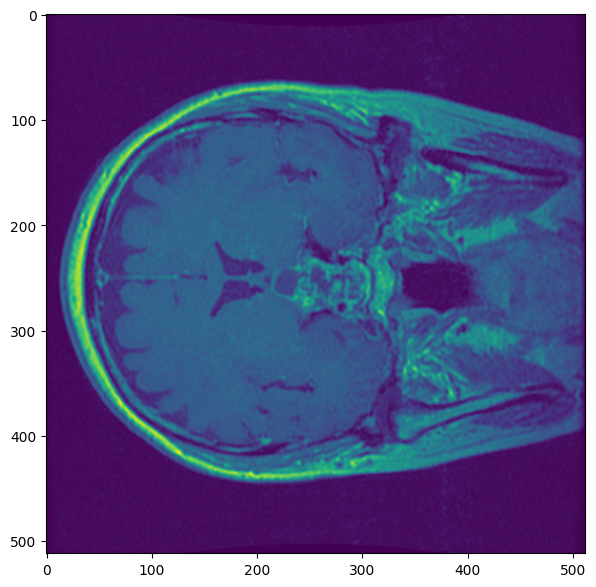

In [14]:
# Checking classification
array = preprocess(image_data) #.to(device)

with torch.no_grad():
  vector = new_vgg19(array[None, :, :, :].cuda())

# Display the image

plt.imshow(image_data) #coloured by plt.imshow()
decode_brain_preds(vector)
print(label) #to check the correct version

# **Interpretability**
Assessing the interpretablity of our model by displaying the saliency maps for random images.

***Download and import packages we need to run the code.***

In [15]:
!pip install torchvision==0.13.0
!pip install git+https://github.com/pytorch/captum.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.


  Cloning https://github.com/pytorch/captum.git to /tmp/pip-req-build-dmplzb3n
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/captum.git /tmp/pip-req-build-dmplzb3n
  Resolved https://github.com/pytorch/captum.git to commit 68d88cf6bec6a0bf73575d2d7be1b2506fdce61c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for captum: filename=captum-0.7.0-py3-none-any.whl size=637238 sha256=ea96c5305c6251b6b5df65e5f4392a87656861f4107ad7dad96fbbf57829f66b
  Stored in directory: /tmp/pip-ephem-wheel-cache-q5nr2un0/wheels/8e/b7/c3/e17a61e561b99ab720ae04e56543dcd69884dee09a09bf5ae4
Successfully built captum


In [16]:
# Import captum
import captum
from captum.attr import visualization as viz
from torchvision import transforms

***Interpretability on the same random image we chose at the start of the code.***

In [17]:
# Setting model to eval mode
new_vgg19.eval()

NewVGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [18]:
image = preprocess(image_data).to(device)
image - image.unsqueeze_(0) #preprocessed image
saliency = captum.attr.Saliency(new_vgg19)
attributions = saliency.attribute(image, target=0) #the attributions obtained from captum

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


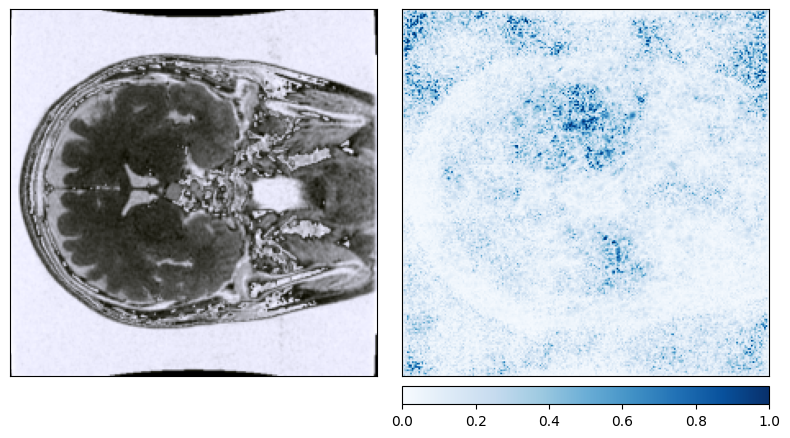

In [19]:
# The preprocessing included normalizing the image which we need invert here
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Your input image to the model.
unnorm_image = inv_normalize(image)

# Display the image and the attribution
_ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)

***Interpretability on 10 random images.***

We did this by:
*  Opening 10 random images from their filepaths with h5py.
*   Preprocessing and decoding them.
*   Displaying the original image alongside predicted label and it's probability.
* Displaying the saliency map.

In [22]:
# Checking what files got randomly assigned to each cagtegory, get the 10 random image filepaths.
# ls tumor_data/train
# ls tumor_data/test
# ls tumor_data/validate


Class: pituitary tumor, Probability: 0.9821684956550598


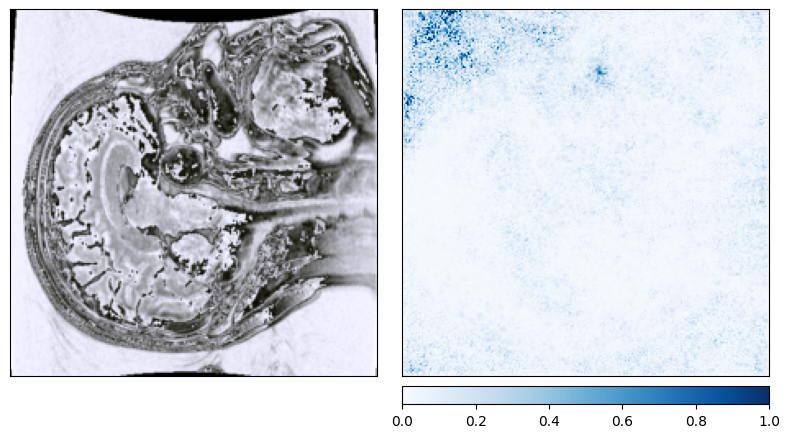


Class: meningioma, Probability: 0.6911877393722534


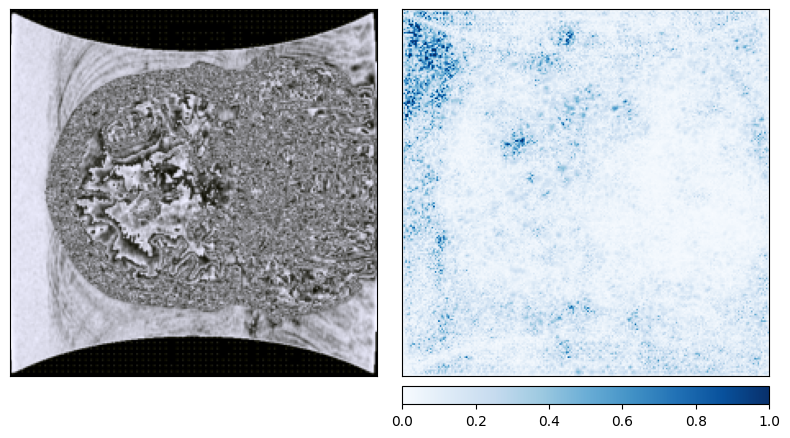


Class: pituitary tumor, Probability: 0.9987517595291138


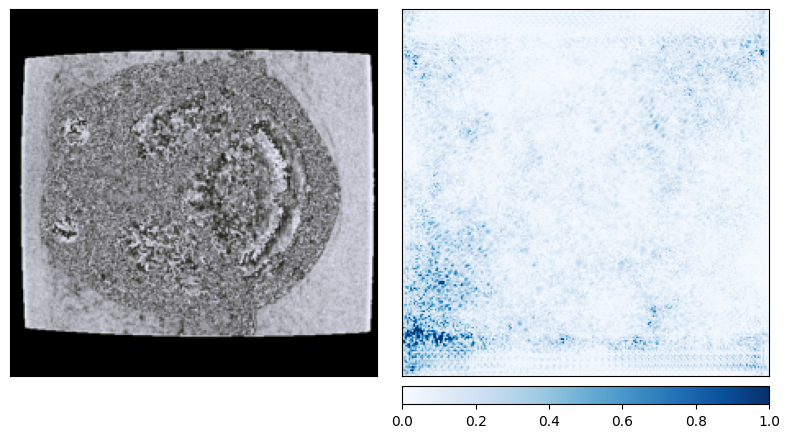


Class: glioma, Probability: 0.9777615070343018


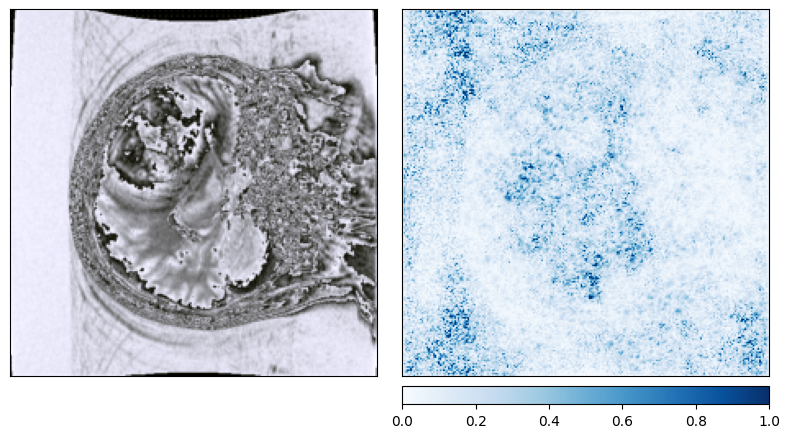


Class: meningioma, Probability: 0.9818861484527588


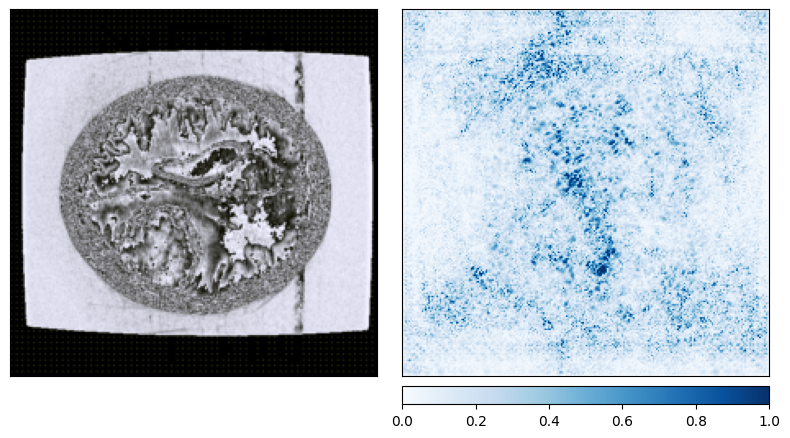


Class: meningioma, Probability: 0.9880629777908325


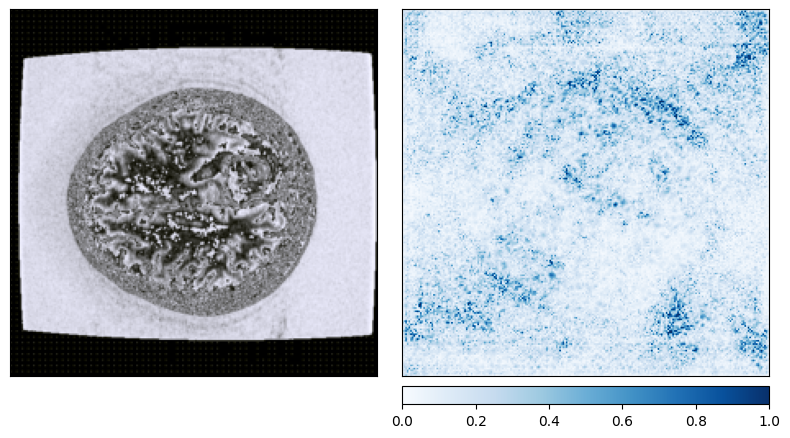


Class: glioma, Probability: 0.8726101517677307


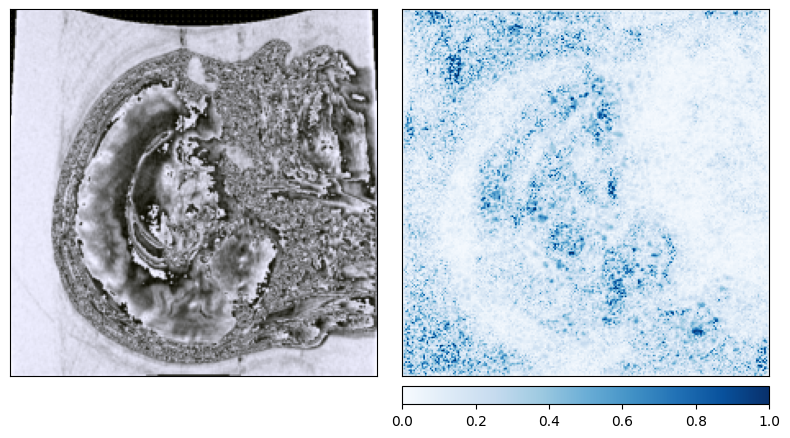


Class: pituitary tumor, Probability: 0.9918314814567566


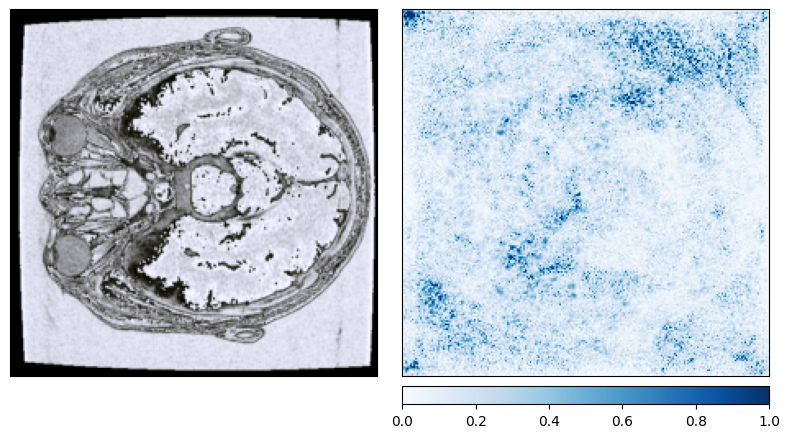


Class: pituitary tumor, Probability: 0.9975269436836243


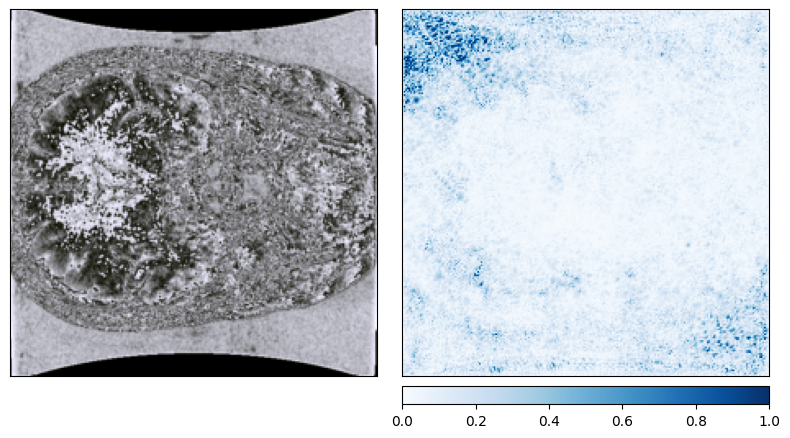


Class: meningioma, Probability: 0.6499543786048889


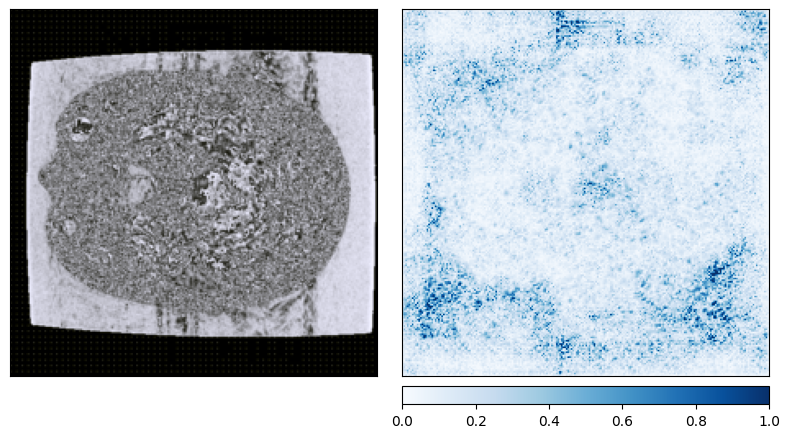


Class: glioma, Probability: 0.9968432188034058


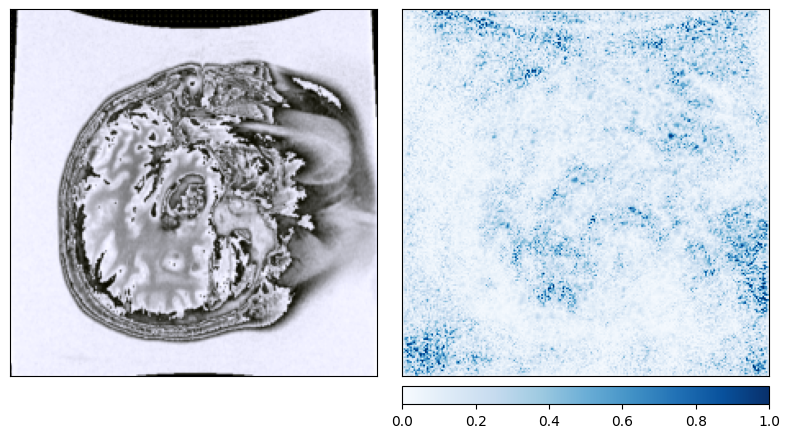


Class: pituitary tumor, Probability: 0.9990274906158447


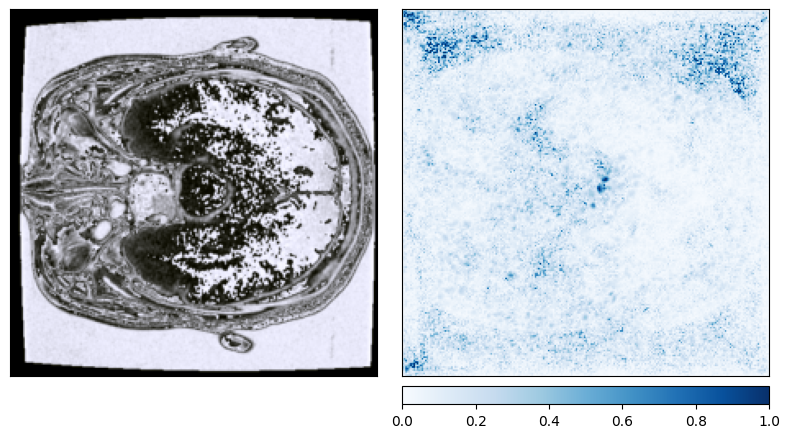

In [28]:
#10 random images
images = ['tumor_data/train/1247.mat', 'tumor_data/train/274.mat', 'tumor_data/train/1003.mat', 'tumor_data/train/910.mat', 'tumor_data/train/171.mat',
          'tumor_data/train/180.mat', 'tumor_data/train/864.mat', 'tumor_data/train/1416.mat',
          'tumor_data/train/1142.mat', 'tumor_data/test/100.mat', 'tumor_data/train/914.mat', 'tumor_data/train/1363.mat']

# Open the .mat file using h5py
for i, image_path in enumerate(images):

  with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    image_data = file['cjdata']['image'][()]

  array = preprocess(image_data).to(device)

  with torch.no_grad():
    vector = new_vgg19(array[None, :, :, :].cuda())
  index = decode_brain_preds(vector)

  saliency = captum.attr.Saliency(new_vgg19)
  image = array.unsqueeze_(0)
  attributions = saliency.attribute(image, target=index)

  # Your input image to the model.
  unnorm_image = inv_normalize(image)

  # Display the image and the attribution
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)